In [ ]:
# !pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.3.2 lightgbm==4.3.0
# !pip install imbalanced-learn==0.11.0 pyarrow fastparquet joblib tqdm matplotlib

import os, glob, warnings, joblib, random
import numpy as np, pandas as pd
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ==== PATHS (chỉnh theo máy bạn) ====
CIC2019_DIR = r'D:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'D:\DACN\dataset\CICDDoS2017'
UNSW15_DIR  = r'D:\DACN\dataset\UNSW_NB15'
NSLKDD_DIR  = r'D:\DACN\dataset\NSL-KDD'   # có KDDTrain+.txt, KDDTest+.txt

# ==== loại cột ID/time ====
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr', 
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])
LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

# kiểm soát lệch phân bố từ UNSW (toàn attack)
MAX_UNSW_RATIO = 0.30   # tối đa 30% số mẫu DDoS từ UNSW trong tập gộp (đổi nếu muốn)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


# GPU (chỉ bật nếu lightgbm GPU đã được build)
USE_LGBM_GPU = False
GPU_PLATFORM_ID = 0
GPU_DEVICE_ID = 0


In [ ]:
def safe_read_any(path: str, nrows=None) -> pd.DataFrame:
    low = path.lower()
    try:
        if low.endswith(".parquet"):
            return pd.read_parquet(path) if nrows is None else pd.read_parquet(path).head(nrows)
        # NSL-KDD .txt không header
        if low.endswith(".txt") and ("kddtrain" in low or "kddtest" in low):
            df = pd.read_csv(path, header=None)
            if df.shape[1] == 43:
                cols = [f"feat_{i}" for i in range(41)] + ["label","difficulty"]
            elif df.shape[1] == 42:
                cols = [f"feat_{i}" for i in range(41)] + ["label"]
            else:
                cols = [f"col_{i}" for i in range(df.shape[1])]
            df.columns = cols
            return df if nrows is None else df.head(nrows)
        # csv chung
        for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
            try:
                return pd.read_csv(path, encoding=enc, compression="infer", low_memory=False, nrows=nrows)
            except Exception:
                continue
        return pd.read_csv(path, compression="infer", low_memory=False, nrows=nrows)
    except Exception as e:
        print(f"[WARN] skip {os.path.basename(path)}: {e}")
        return pd.DataFrame()

def find_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    return None

# map AttackType như code gốc
attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lbl = find_label_col(df)
    if lbl is None:
        return pd.DataFrame()  # bỏ file không có nhãn
    df.rename(columns={lbl: "Label"}, inplace=True)
    df["Label"] = df["Label"].astype(str).str.strip()
    df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
    if "AttackType" not in df.columns:
        df["AttackType"] = df["Label"]
    def group_attack_type(x):
        if pd.isna(x): return 'Other'
        if x == 'Benign': return 'Benign'
        return attack_group_map.get(str(x), 'Other')
    df["AttackType"] = df["AttackType"].apply(group_attack_type)
    df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
    return df


In [ ]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: chỉ lấy các file có nhãn (bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv)
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL (txt):", len(nsl_files))

# union numeric + dataset_id
def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: 
            continue
        head = normalize_labels(head)
        if head.empty: 
            continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, "feature_order_union.pkl")


In [ ]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: chỉ lấy các file có nhãn (bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv)
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL (txt):", len(nsl_files))

# union numeric + dataset_id
def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: 
            continue
        head = normalize_labels(head)
        if head.empty: 
            continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, "feature_order_union.pkl")


CIC19 train: 7 CIC19 test: 10
CIC17: 8 UNSW: 18 NSL (txt): 4
Tổng số cột numeric union: 117


['feature_order_union.pkl']

In [ ]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: chỉ lấy các file có nhãn (bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv)
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL (txt):", len(nsl_files))

# union numeric + dataset_id
def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: 
            continue
        head = normalize_labels(head)
        if head.empty: 
            continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, "feature_order_union.pkl")


In [ ]:
# chọn numeric union
drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in df_all.columns if c in ID_LIKE_COLS}
feature_candidates = [c for c in FEATURES if c not in drop_cols and c in df_all.columns]
print("Số cột dùng:", len(feature_candidates))

X = df_all.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
y_bin = (df_all['Label'] != 'Benign').astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

# scaler + SMOTE như gốc
scaler = MinMaxScaler()
scaler.fit(X_train_raw.values)
joblib.dump(scaler, 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_raw.values)
X_test_s  = scaler.transform(X_test_raw.values)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| pos_ratio:", y_res.mean().round(4))


Validation: (306201, 117) Pos ratio: 0.8321233438166433


In [ ]:
# bạn có thể tăng n_estimators từng "epoch" để nhẹ hơn
EPOCHS = 3
ROUND_PER_EPOCH = 500   # mỗi epoch tăng thêm 500 cây

clf_bin = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight='balanced',
    n_estimators=ROUND_PER_EPOCH,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1,
    # warm_start cho phép tăng n_estimators dần
    warm_start=True
)

for e in range(EPOCHS):
    clf_bin.n_estimators = (e+1)*ROUND_PER_EPOCH
    clf_bin.fit(
        X_res, y_res,
        eval_set=[(X_test_s, y_test)],
        eval_metric=['auc','binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )
    print(f"[✓] Epoch {e+1}/{EPOCHS} — best_iter: {clf_bin.best_iteration_}")

joblib.dump({'model': clf_bin, 'scaler': scaler, 'feature_order': feature_candidates},
            'lgbm_binary_union.joblib')

# đánh giá
y_prob = clf_bin.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks([0,1],["Benign","DDoS"]); plt.yticks([0,1],["Benign","DDoS"])
plt.title("Confusion Matrix - Phase 1 (Binary - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred, target_names=['Benign','DDoS']))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


=== Phase-1 (Binary) — 3 epoch, quota 2,000,000 mẫu/epoch ===
[LightGBM] [Info] Number of positive: 128014, number of negative: 93250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6985
[LightGBM] [Info] Number of data points in the train set: 221264, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.578558 -> initscore=0.316856
[LightGBM] [Info] Start training from score 0.316856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

              precision    recall  f1-score   support

      Benign       0.48      1.00      0.65     51404
        DDoS       1.00      0.78      0.88    254797

    accuracy                           0.82    306201
   macro avg       0.74      0.89      0.76    306201
weighted avg       0.91      0.82      0.84    306201

ROC-AUC: 0.9295762065415046


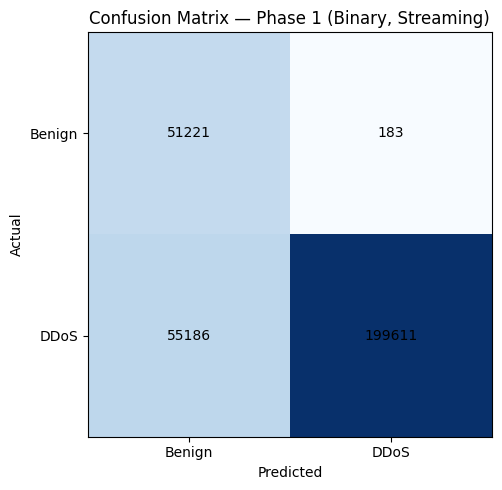

In [ ]:
# lấy toàn bộ mẫu DDoS
df_attack = df_all[df_all['Label']=='DDoS'].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32).values
X_attack_s = scaler.transform(X_attack)

# nhãn đa lớp
y_attack_txt = df_attack['AttackType'].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
n_classes = len(le_attack.classes_)
joblib.dump(le_attack, "attack_label_encoder_union.pkl")
print("Classes:", list(le_attack.classes_))

# SMOTE đa lớp
X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)

# chia train/test theo stratified
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res
)

# trọng số theo tần suất đảo để ổn định hơn
counts = pd.Series(ya_tr).value_counts()
inv_ratio = counts.max() / counts
sample_weight = pd.Series(ya_tr).map(inv_ratio).values

clf_multi = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=1600,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

clf_multi.fit(
    Xa_tr, ya_tr,
    sample_weight=sample_weight,
    eval_set=[(Xa_te, ya_te)],
    eval_metric=['multi_logloss'],
    callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
)

joblib.dump({
    'model': clf_multi,
    'scaler': scaler,
    'feature_order': feature_candidates,
    'attack_label_encoder': le_attack
}, 'lgbm_attack_union.joblib')

# Đánh giá trên phần DDoS thuộc tập test của Cell 5
test_mask_ddos = (y_test == 1)
X_attack_test = X_test_s[test_mask_ddos]
y_attack_test_txt = df_all.iloc[X_test_raw.index][test_mask_ddos]['AttackType'].astype(str).values  # tương ứng order

# map nhãn test -> encoder
y_attack_test = []
for t in y_attack_test_txt:
    if t in le_attack.classes_:
        y_attack_test.append(le_attack.transform([t])[0])
    else:
        # nếu có nhãn lạ → gộp "Other" nếu tồn tại, ngược lại bỏ
        if "Other" in le_attack.classes_:
            y_attack_test.append(le_attack.transform(["Other"])[0])
        else:
            # bỏ trường hợp hiếm không map được
            y_attack_test.append(-1)
y_attack_test = np.array([v for v in y_attack_test if v >= 0])

# dự đoán
y_attack_pred = clf_multi.predict(X_attack_test[:len(y_attack_test)])

labels_multi = le_attack.classes_
cm2 = confusion_matrix(y_attack_test, y_attack_pred)
plt.figure(figsize=(12,9))
plt.imshow(cm2, cmap='YlGnBu')
for (i,j),v in np.ndenumerate(cm2): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks(range(len(labels_multi)), labels_multi, rotation=30, ha="right")
plt.yticks(range(len(labels_multi)), labels_multi)
plt.title("Confusion Matrix - Phase 2 (Multiclass - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_attack_test, y_attack_pred, target_names=labels_multi))


In [24]:
res_X, res_y = [], []
cur = 0

for ds_id, files in train_plan:
    for path in files:
        for chunk in iter_read_chunks(path, CHUNKSIZE):
            X, yb, ym = align_chunk(chunk, dataset_id=ds_id, feature_order=feature_order)
            if X.shape[0] == 0: continue
            mask = (yb == 1)
            if not mask.any(): continue
            Xa = X[mask]
            ya = np.array([t for m, t in zip(mask, ym) if m])

            take = min(len(Xa), RESERVOIR_MAX - cur)
            if take <= 0: break
            idx = np.random.choice(len(Xa), size=take, replace=False)
            res_X.append(Xa[idx]); res_y.append(ya[idx])
            cur += take
        if cur >= RESERVOIR_MAX: break
    if cur >= RESERVOIR_MAX: break

if cur == 0:
    print("[WARN] Không thu được mẫu DDoS cho phase-2")
else:
    X_phase2 = np.vstack(res_X)
    y_phase2 = np.concatenate(res_y)
    print("Reservoir Phase-2:", X_phase2.shape, "unique:", pd.Series(y_phase2).value_counts().to_dict())
    joblib.dump({"X": X_phase2, "y": y_phase2, "feature_order": feature_order}, "phase2_reservoir.pkl")


Reservoir Phase-2: (600000, 117) unique: {'Other': 315592, 'DoS': 193745, 'Syn': 48840, 'UDP': 18145, 'Brute Force': 9150, 'MSSQL': 8523, 'Web Attack': 2143, 'PortScan': 1956, 'LDAP': 1906}


In [25]:
from sklearn.preprocessing import LabelEncoder

pack = joblib.load("phase2_reservoir.pkl")
X_phase2 = pack["X"]; y_phase2 = pack["y"]

le_attack = LabelEncoder()
y2_enc = le_attack.fit_transform(y_phase2)
n_classes = len(le_attack.classes_)
print("Classes:", list(le_attack.classes_))

# validation phần DDoS
mask_val_ddos = (y_valid_bin == 1)
X_val2 = X_valid[mask_val_ddos]
y_val2 = y_valid_mult[mask_val_ddos]
y_val2 = np.array([t if t in le_attack.classes_ else "Other" for t in y_val2])
y_val2 = le_attack.transform(y_val2)

params_multi = dict(
    objective="multiclass",
    num_class=n_classes,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_data_in_leaf=100,
    max_bin=127,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
if USE_LGBM_GPU:
    params_multi.update(dict(device="gpu", gpu_platform_id=GPU_PLATFORM_ID, gpu_device_id=GPU_DEVICE_ID))

dtrain2 = lgb.Dataset(X_phase2, label=y2_enc)
dvalid2 = lgb.Dataset(X_val2, label=y_val2) if X_val2.shape[0] else None

clf_multi = lgb.train(
    params_multi,
    train_set=dtrain2,
    num_boost_round=1600,
    valid_sets=[dvalid2] if dvalid2 is not None else None,
    valid_names=["valid"],
    callbacks=[lgb.early_stopping(80, verbose=False)]
)

clf_multi.save_model("lgbm_multiclass_stream.txt")
joblib.dump({"label_encoder": le_attack, "feature_order": feature_order}, "lgbm_multiclass_meta.joblib")

y_pred2 = clf_multi.predict(X_val2).argmax(axis=1)
print(classification_report(y_val2, y_pred2, target_names=list(le_attack.classes_)))

cm2 = confusion_matrix(y_val2, y_pred2)
plt.figure(figsize=(10,8))
plt.imshow(cm2, cmap="YlGnBu")
for (i,j),v in np.ndenumerate(cm2):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xticks(range(n_classes), le_attack.classes_, rotation=30, ha="right")
plt.yticks(range(n_classes), le_attack.classes_)
plt.title("Confusion Matrix — Phase 2 (Multiclass, Streaming)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()


Classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9308
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 106
[LightGBM] [Info] Start training from score -4.183176
[LightGBM] [Info] Start training from score -1.130387
[LightGBM] [Info] Start training from score -5.751923
[LightGBM] [Info] Start training from score -4.254161
[LightGBM] [Info] Start training from score -0.642479
[LightGBM] [Info] Start training from score -5.726028
[LightGBM] [Info] Start training from score -2.508380
[LightGBM] [Info] Start training from score -3.498535
[LightGBM] [Info] Start training from score -5.634723
[LightGBM] [Warning] No further splits with positive gain, be

ValueError: Number of classes, 4, does not match size of target_names, 9. Try specifying the labels parameter

In [26]:
# === Đếm số mẫu hiệu dụng (sau align_chunk) cho 4 dataset ===
from math import ceil

def count_effective(files_plan, feature_order):
    stats = {
        1: {"name":"CIC-2017", "rows":0, "pos":0, "neg":0},
        2: {"name":"CIC-2019-train/test", "rows":0, "pos":0, "neg":0},
        3: {"name":"UNSW-NB15", "rows":0, "pos":0, "neg":0},
        4: {"name":"NSL-KDD (txt)", "rows":0, "pos":0, "neg":0},
    }
    total_rows = total_pos = total_neg = 0

    for ds_id, files in files_plan:
        for path in files:
            for chunk in iter_read_chunks(path, CHUNKSIZE):
                Xb, yb, _ = align_chunk(chunk, dataset_id=ds_id, feature_order=feature_order)
                n = len(yb)
                if n == 0: 
                    continue
                p = int((yb == 1).sum())
                q = n - p
                stats[ds_id]["rows"] += n
                stats[ds_id]["pos"]  += p
                stats[ds_id]["neg"]  += q
                total_rows += n
                total_pos  += p
                total_neg  += q

    return stats, total_rows, total_pos, total_neg

# NSL chỉ lấy .txt như đã sửa ở Cell 4
train_plan_for_count = [
    (1, cic17_files),
    (2, cic19_train + cic19_test),  # đếm cả test để biết tổng (train vẫn chỉ dùng train)
    (3, unsw_files),
    (4, nsl_files)
]

stats, total_rows, total_pos, total_neg = count_effective(train_plan_for_count, feature_order)

print("=== Hiệu dụng theo bộ ===")
for ds_id in [1,2,3,4]:
    s = stats[ds_id]
    if s["rows"] == 0:
        print(f"- {s['name']}: 0 mẫu")
    else:
        r = s["rows"]; pos = s["pos"]; neg = s["neg"]
        print(f"- {s['name']}: {r:,} mẫu  |  Benign: {neg:,}  |  DDoS: {pos:,}  |  pos_ratio: {(pos/r):.4f}")

print("\n=== Tổng cộng ===")
print(f"Tổng mẫu: {total_rows:,}  |  Benign: {total_neg:,}  |  DDoS: {total_pos:,}  |  pos_ratio: {(total_pos/total_rows):.4f}")

# Gợi ý số epoch theo quota bạn đặt
rows_per_epoch = MAX_ROWS_PER_EPOCH
epochs_needed = ceil(total_rows / rows_per_epoch) if rows_per_epoch > 0 else 1
print(f"\nGợi ý epochs với quota {rows_per_epoch:,}/epoch: {epochs_needed} epoch(s)")


=== Hiệu dụng theo bộ ===
- CIC-2017: 2,313,810 mẫu  |  Benign: 1,977,318  |  DDoS: 336,492  |  pos_ratio: 0.1454
- CIC-2019-train/test: 431,371 mẫu  |  Benign: 97,831  |  DDoS: 333,540  |  pos_ratio: 0.7732
- UNSW-NB15: 515,346 mẫu  |  Benign: 0  |  DDoS: 515,346  |  pos_ratio: 1.0000
- NSL-KDD (txt): 185,555 mẫu  |  Benign: 92,653  |  DDoS: 92,902  |  pos_ratio: 0.5007

=== Tổng cộng ===
Tổng mẫu: 3,446,082  |  Benign: 2,167,802  |  DDoS: 1,278,280  |  pos_ratio: 0.3709

Gợi ý epochs với quota 2,000,000/epoch: 2 epoch(s)
